In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import joblib # To save/load models
import warnings

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

print("Libraries loaded successfully!")

Libraries loaded successfully!


In [3]:
df = pd.read_csv('data.csv')
print("Data loaded successfully!")


print("\n--- Initial Data Inspection ---")
print("Dataset Head:")
print(df.head())

print("\nDataset Info:")
df.info()

print("\nMissing Values Before Preprocessing:")
print(df.isnull().sum())

print("\nBasic Statistics:")
print(df.describe())

Data loaded successfully!

--- Initial Data Inspection ---
Dataset Head:
    Loan_ID Gender Married Dependents     Education Self_Employed  \
0  LP001002   Male      No          0      Graduate            No   
1  LP001003   Male     Yes          1      Graduate            No   
2  LP001005   Male     Yes          0      Graduate           Yes   
3  LP001006   Male     Yes          0  Not Graduate            No   
4  LP001008   Male      No          0      Graduate            No   

   ApplicantIncome  CoapplicantIncome  LoanAmount  Loan_Amount_Term  \
0             5849                0.0         NaN             360.0   
1             4583             1508.0       128.0             360.0   
2             3000                0.0        66.0             360.0   
3             2583             2358.0       120.0             360.0   
4             6000                0.0       141.0             360.0   

   Credit_History Property_Area Loan_Status  
0             1.0         Urban        

In [4]:

# Convert 'Loan_Status' to numerical (0 for N, 1 for Y)
df['Loan_Status'] = df['Loan_Status'].map({'N': 0, 'Y': 1})

# Convert 'Dependents' to numerical. Handle the '3+' case.
# If 'Dependents' has NaNs, they will become NaN here and be handled by the imputer later.
df['Dependents'] = df['Dependents'].replace('3+', '3').astype(float)

# Drop Loan_ID as it's just an identifier
df = df.drop('Loan_ID', axis=1)

print("\nDataset Head after initial transformations and Loan_ID drop:")
print(df.head())


Dataset Head after initial transformations and Loan_ID drop:
  Gender Married  Dependents     Education Self_Employed  ApplicantIncome  \
0   Male      No         0.0      Graduate            No             5849   
1   Male     Yes         1.0      Graduate            No             4583   
2   Male     Yes         0.0      Graduate           Yes             3000   
3   Male     Yes         0.0  Not Graduate            No             2583   
4   Male      No         0.0      Graduate            No             6000   

   CoapplicantIncome  LoanAmount  Loan_Amount_Term  Credit_History  \
0                0.0         NaN             360.0             1.0   
1             1508.0       128.0             360.0             1.0   
2                0.0        66.0             360.0             1.0   
3             2358.0       120.0             360.0             1.0   
4                0.0       141.0             360.0             1.0   

  Property_Area  Loan_Status  
0         Urban        

 Exploratory Data Analysis (EDA)

This cell focuses on visualizing the distributions and relationships within the data using matplotlib and seaborn.

--- Exploratory Data Analysis (EDA) ---


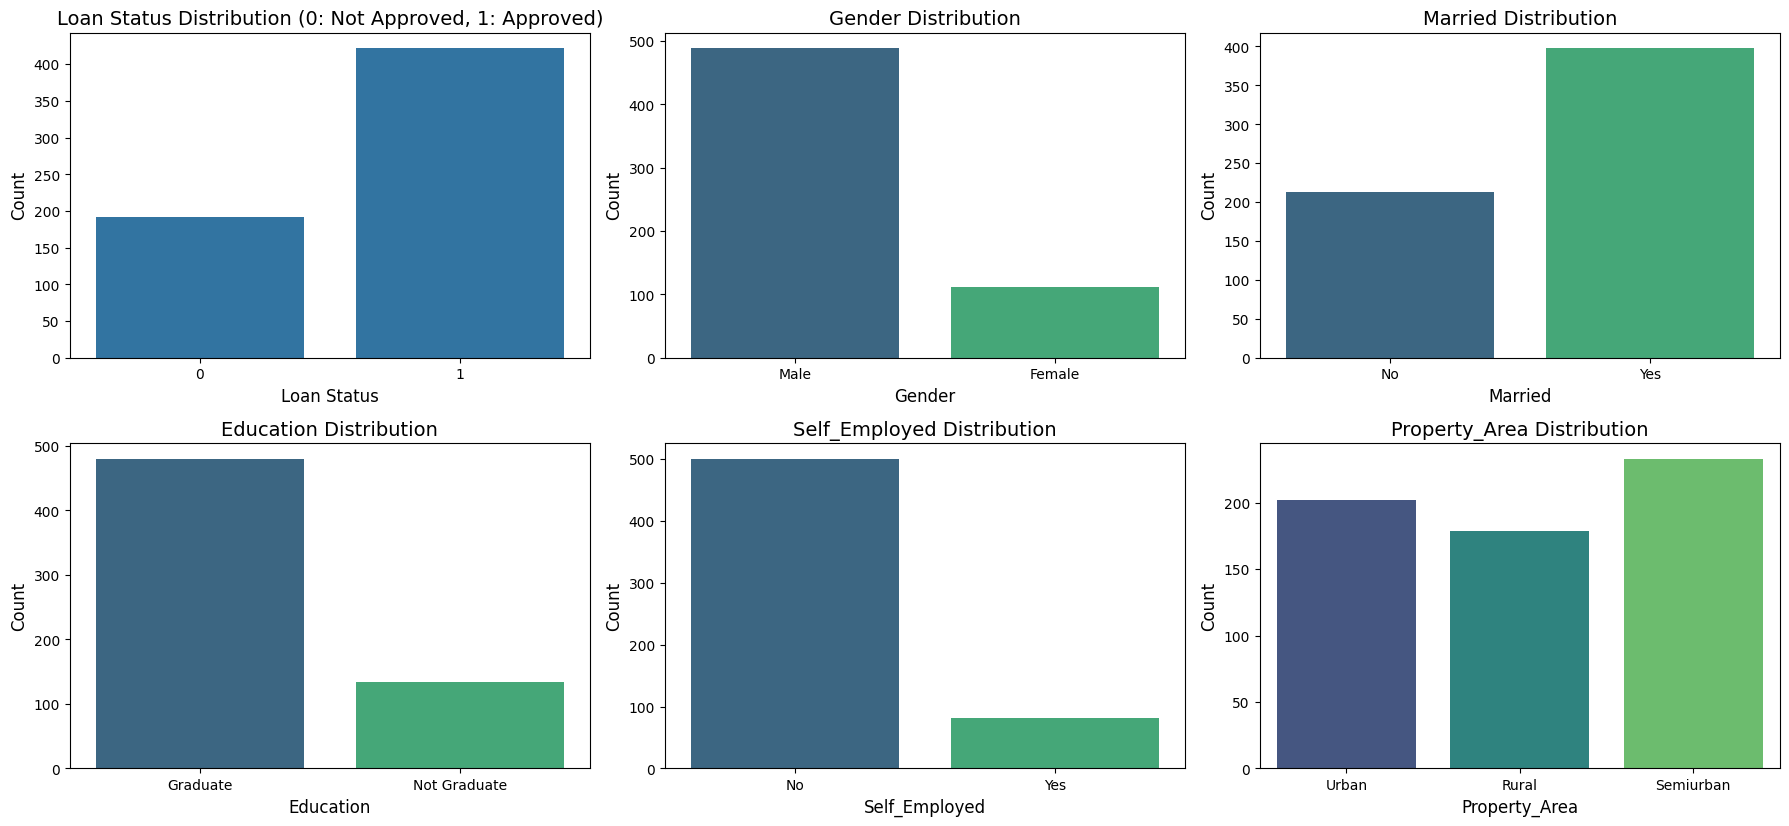

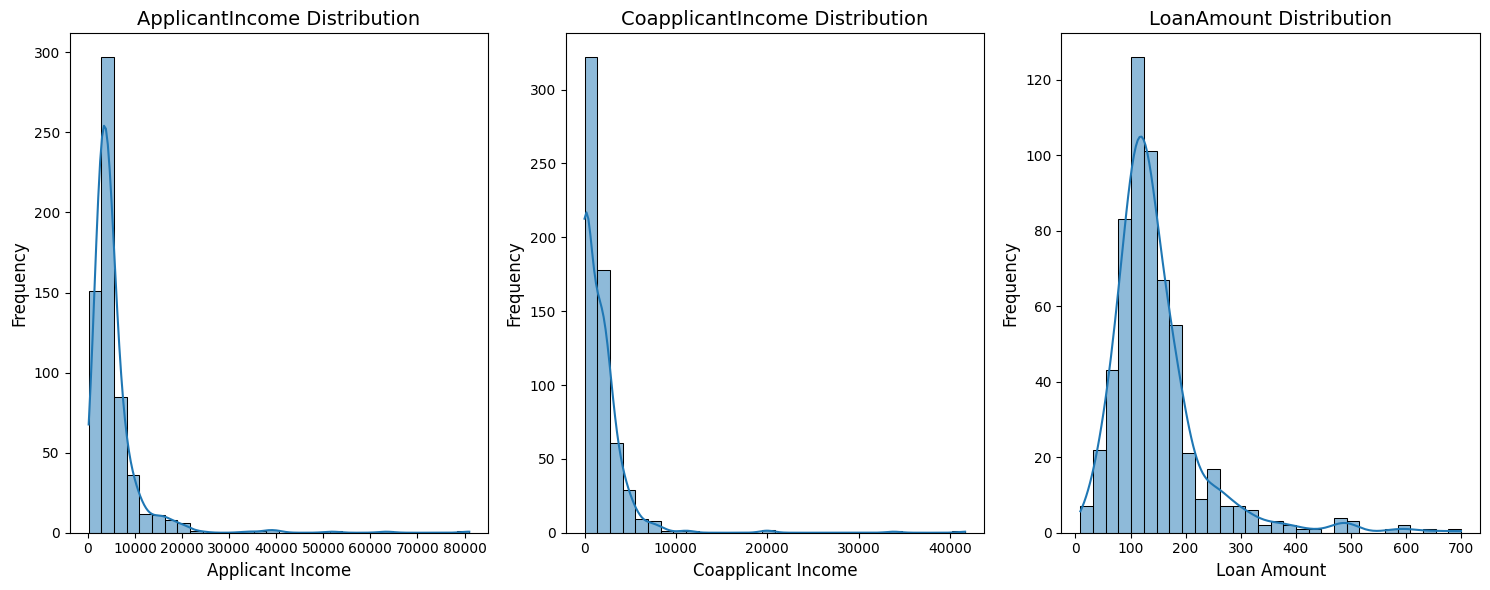

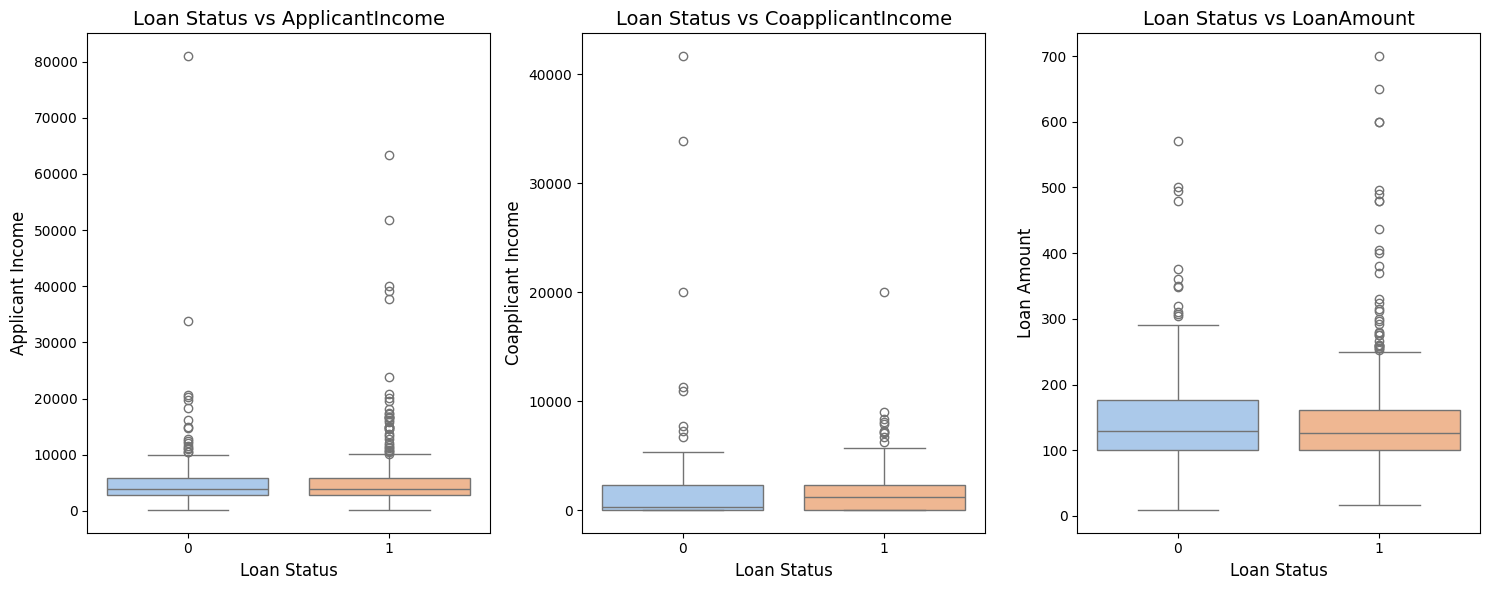

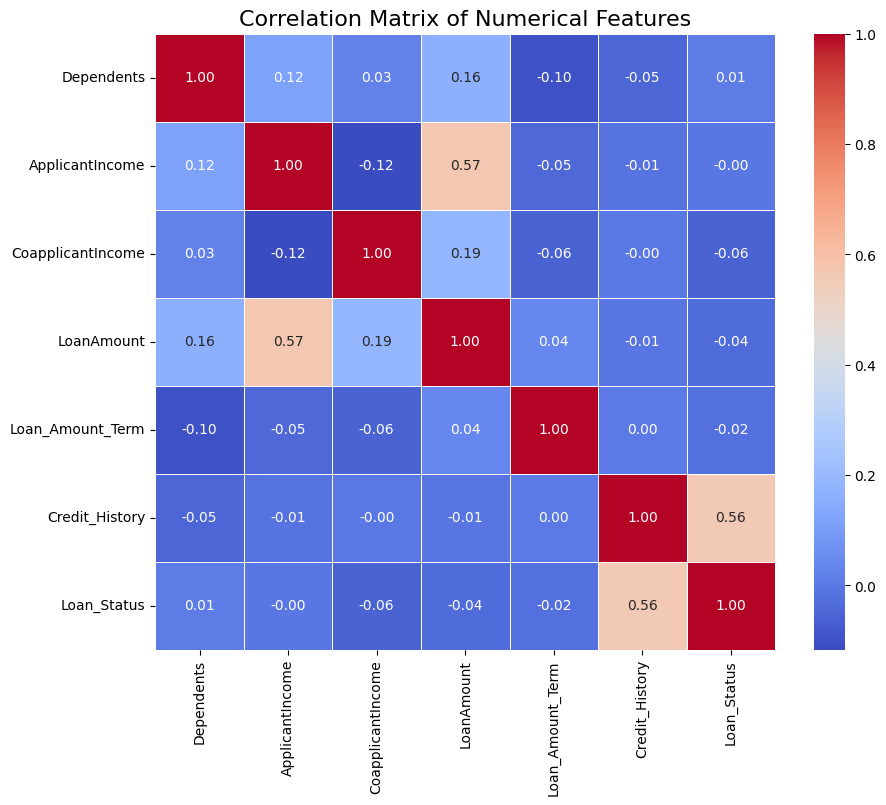

In [5]:
print("--- Exploratory Data Analysis (EDA) ---")

plt.figure(figsize=(18, 12))

# Distribution of Loan_Status
plt.subplot(3, 3, 1)
sns.countplot(x='Loan_Status', data=df)
plt.title('Loan Status Distribution (0: Not Approved, 1: Approved)', fontsize=14)
plt.xlabel('Loan Status', fontsize=12)
plt.ylabel('Count', fontsize=12)

# Distribution of Categorical Features
categorical_cols_for_plot = ['Gender', 'Married', 'Education', 'Self_Employed', 'Property_Area']
for i, col in enumerate(categorical_cols_for_plot):
    plt.subplot(3, 3, i + 2)
    sns.countplot(x=col, data=df, palette='viridis')
    plt.title(f'{col} Distribution', fontsize=14)
    plt.xlabel(col, fontsize=12)
    plt.ylabel('Count', fontsize=12)

plt.tight_layout()
plt.show()

# Numerical Feature Distributions
plt.figure(figsize=(15, 6))

plt.subplot(1, 3, 1)
sns.histplot(df['ApplicantIncome'].dropna(), kde=True, bins=30)
plt.title('ApplicantIncome Distribution', fontsize=14)
plt.xlabel('Applicant Income', fontsize=12)
plt.ylabel('Frequency', fontsize=12)

plt.subplot(1, 3, 2)
sns.histplot(df['CoapplicantIncome'].dropna(), kde=True, bins=30)
plt.title('CoapplicantIncome Distribution', fontsize=14)
plt.xlabel('Coapplicant Income', fontsize=12)
plt.ylabel('Frequency', fontsize=12)

plt.subplot(1, 3, 3)
sns.histplot(df['LoanAmount'].dropna(), kde=True, bins=30)
plt.title('LoanAmount Distribution', fontsize=14)
plt.xlabel('Loan Amount', fontsize=12)
plt.ylabel('Frequency', fontsize=12)

plt.tight_layout()
plt.show()

# Relationship between numerical features and Loan_Status
plt.figure(figsize=(15, 6))

plt.subplot(1, 3, 1)
sns.boxplot(x='Loan_Status', y='ApplicantIncome', data=df, palette='pastel')
plt.title('Loan Status vs ApplicantIncome', fontsize=14)
plt.xlabel('Loan Status', fontsize=12)
plt.ylabel('Applicant Income', fontsize=12)

plt.subplot(1, 3, 2)
sns.boxplot(x='Loan_Status', y='CoapplicantIncome', data=df, palette='pastel')
plt.title('Loan Status vs CoapplicantIncome', fontsize=14)
plt.xlabel('Loan Status', fontsize=12)
plt.ylabel('Coapplicant Income', fontsize=12)

plt.subplot(1, 3, 3)
sns.boxplot(x='Loan_Status', y='LoanAmount', data=df, palette='pastel')
plt.title('Loan Status vs LoanAmount', fontsize=14)
plt.xlabel('Loan Status', fontsize=12)
plt.ylabel('Loan Amount', fontsize=12)

plt.tight_layout()
plt.show()

# Correlation Heatmap for Numerical Features
plt.figure(figsize=(10, 8))
sns.heatmap(df.select_dtypes(include=np.number).corr(), annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Matrix of Numerical Features', fontsize=16)
plt.show()

Feature Engineering

Creating new features that might provide more predictive power to the models.

In [6]:
print("--- Feature Engineering ---")

# Total Income
df['TotalIncome'] = df['ApplicantIncome'] + df['CoapplicantIncome']

# Loan Amount per Term (consider if relevant based on business understanding)
# df['LoanAmount_per_Term'] = df['LoanAmount'] / df['Loan_Amount_Term']

# Loan Amount to Income Ratio
# Adding a small epsilon to TotalIncome to avoid division by zero
df['LoanAmount_to_Income_Ratio'] = df['LoanAmount'] / (df['TotalIncome'] + 1e-6)

print("\nDataset Head after Feature Engineering:")
print(df.head())

--- Feature Engineering ---

Dataset Head after Feature Engineering:
  Gender Married  Dependents     Education Self_Employed  ApplicantIncome  \
0   Male      No         0.0      Graduate            No             5849   
1   Male     Yes         1.0      Graduate            No             4583   
2   Male     Yes         0.0      Graduate           Yes             3000   
3   Male     Yes         0.0  Not Graduate            No             2583   
4   Male      No         0.0      Graduate            No             6000   

   CoapplicantIncome  LoanAmount  Loan_Amount_Term  Credit_History  \
0                0.0         NaN             360.0             1.0   
1             1508.0       128.0             360.0             1.0   
2                0.0        66.0             360.0             1.0   
3             2358.0       120.0             360.0             1.0   
4                0.0       141.0             360.0             1.0   

  Property_Area  Loan_Status  TotalIncome  Loan

 Data Preprocessing Pipeline (Missing Values & Categorical Encoding)

This is a critical step using ColumnTransformer and Pipeline for robust preprocessing.

In [7]:
print("--- Data Preprocessing Pipeline ---")

# Define target variable
y = df['Loan_Status']
X = df.drop('Loan_Status', axis=1)

# Define categorical and numerical features
# Ensure these lists match your DataFrame columns after initial drops/engineering
categorical_features = ['Gender', 'Married', 'Education', 'Self_Employed', 'Property_Area']
numerical_features = ['Dependents', 'ApplicantIncome', 'CoapplicantIncome', 'LoanAmount',
                      'Loan_Amount_Term', 'Credit_History', 'TotalIncome', 'LoanAmount_to_Income_Ratio']

# Create preprocessing pipelines for numerical and categorical features
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')), # Impute missing numerical values with median
    ('scaler', StandardScaler()) # Scale numerical features
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')), # Impute missing categorical values with mode
    ('onehot', OneHotEncoder(handle_unknown='ignore')) # One-hot encode categorical features
])

# Create a preprocessor using ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder='passthrough' # Keep other columns if any, though not expected here
)

print("\nPreprocessing pipeline defined.")

--- Data Preprocessing Pipeline ---

Preprocessing pipeline defined.


Train-Test Split

Splitting the data into training and testing sets to evaluate model generalization.

In [8]:
print("--- Train/Test Split ---")

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

--- Train/Test Split ---
X_train shape: (491, 13)
X_test shape: (123, 13)
y_train shape: (491,)
y_test shape: (123,)


Model Training & Evaluation (Logistic Regression)

Training and evaluating the Logistic Regression model.

In [9]:
print("\n--- Training Logistic Regression Model ---")

lr_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              ('classifier', LogisticRegression(random_state=42, solver='liblinear'))])

lr_pipeline.fit(X_train, y_train)
y_pred_lr = lr_pipeline.predict(X_test)
y_proba_lr = lr_pipeline.predict_proba(X_test)[:, 1] # Probability of the positive class

print("\nLogistic Regression Performance on Test Set:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_lr):.4f}")
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_lr))
print("Classification Report:\n", classification_report(y_test, y_pred_lr))

fpr_lr, tpr_lr, _ = roc_curve(y_test, y_proba_lr)
roc_auc_lr = auc(fpr_lr, tpr_lr)
print(f"ROC-AUC: {roc_auc_lr:.4f}")


--- Training Logistic Regression Model ---

Logistic Regression Performance on Test Set:
Accuracy: 0.8618
Confusion Matrix:
 [[22 16]
 [ 1 84]]
Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.58      0.72        38
           1       0.84      0.99      0.91        85

    accuracy                           0.86       123
   macro avg       0.90      0.78      0.81       123
weighted avg       0.88      0.86      0.85       123

ROC-AUC: 0.8697


Model Training & Evaluation (Random Forest Classifier)

Training and evaluating the Random Forest Classifier.

In [10]:
print("\n--- Training Random Forest Classifier Model ---")

rf_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              ('classifier', RandomForestClassifier(random_state=42))])

rf_pipeline.fit(X_train, y_train)
y_pred_rf = rf_pipeline.predict(X_test)
y_proba_rf = rf_pipeline.predict_proba(X_test)[:, 1]

print("\nRandom Forest Performance on Test Set:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_rf):.4f}")
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_rf))
print("Classification Report:\n", classification_report(y_test, y_pred_rf))

fpr_rf, tpr_rf, _ = roc_curve(y_test, y_proba_rf)
roc_auc_rf = auc(fpr_rf, tpr_rf)
print(f"ROC-AUC: {roc_auc_rf:.4f}")


--- Training Random Forest Classifier Model ---

Random Forest Performance on Test Set:
Accuracy: 0.8537
Confusion Matrix:
 [[26 12]
 [ 6 79]]
Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.68      0.74        38
           1       0.87      0.93      0.90        85

    accuracy                           0.85       123
   macro avg       0.84      0.81      0.82       123
weighted avg       0.85      0.85      0.85       123

ROC-AUC: 0.8663


 Model Training & Evaluation (XGBoost Classifier)

Training and evaluating the XGBoost Classifier.

In [11]:
print("\n--- Training XGBoost Classifier Model ---")

xgb_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                               ('classifier', XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss'))])

xgb_pipeline.fit(X_train, y_train)
y_pred_xgb = xgb_pipeline.predict(X_test)
y_proba_xgb = xgb_pipeline.predict_proba(X_test)[:, 1]

print("\nXGBoost Performance on Test Set:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_xgb):.4f}")
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_xgb))
print("Classification Report:\n", classification_report(y_test, y_pred_xgb))

fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_proba_xgb)
roc_auc_xgb = auc(fpr_xgb, tpr_xgb)
print(f"ROC-AUC: {roc_auc_xgb:.4f}")


--- Training XGBoost Classifier Model ---

XGBoost Performance on Test Set:
Accuracy: 0.8211
Confusion Matrix:
 [[27 11]
 [11 74]]
Classification Report:
               precision    recall  f1-score   support

           0       0.71      0.71      0.71        38
           1       0.87      0.87      0.87        85

    accuracy                           0.82       123
   macro avg       0.79      0.79      0.79       123
weighted avg       0.82      0.82      0.82       123

ROC-AUC: 0.8303


 Cross-Validation

Using cross-validation for a more robust evaluation of model performance.

In [12]:
print("\n--- Cross-Validation Scores (5-Fold) ---")

# For Logistic Regression
cv_scores_lr = cross_val_score(lr_pipeline, X, y, cv=5, scoring='accuracy', n_jobs=-1)
print(f"Logistic Regression CV Accuracy: {cv_scores_lr.mean():.4f} (+/- {cv_scores_lr.std():.4f})")

# For Random Forest
cv_scores_rf = cross_val_score(rf_pipeline, X, y, cv=5, scoring='accuracy', n_jobs=-1)
print(f"Random Forest CV Accuracy: {cv_scores_rf.mean():.4f} (+/- {cv_scores_rf.std():.4f})")

# For XGBoost
cv_scores_xgb = cross_val_score(xgb_pipeline, X, y, cv=5, scoring='accuracy', n_jobs=-1)
print(f"XGBoost CV Accuracy: {cv_scores_xgb.mean():.4f} (+/- {cv_scores_xgb.std():.4f})")


--- Cross-Validation Scores (5-Fold) ---
Logistic Regression CV Accuracy: 0.8062 (+/- 0.0309)
Random Forest CV Accuracy: 0.7997 (+/- 0.0199)
XGBoost CV Accuracy: 0.7866 (+/- 0.0244)


Hyperparameter Tuning (GridSearchCV for Random Forest)

An example of using GridSearchCV to find the best hyperparameters for the Random Forest model. This can be time-consuming for large grids/datasets.

In [13]:
print("\n--- Hyperparameter Tuning (Random Forest using GridSearchCV) ---")

# Define a smaller parameter grid for demonstration to keep execution time reasonable
param_grid_rf = {
    'classifier__n_estimators': [50, 100, 200], # Number of trees in the forest
    'classifier__max_depth': [5, 10, None],   # Maximum depth of the tree (None means unlimited)
    'classifier__min_samples_split': [2, 5, 10] # Minimum number of samples required to split an internal node
}

# Create GridSearchCV object
grid_search_rf = GridSearchCV(rf_pipeline, param_grid_rf, cv=3, scoring='accuracy', n_jobs=-1, verbose=1)

# Fit on training data
grid_search_rf.fit(X_train, y_train)

print(f"\nBest Parameters for Random Forest: {grid_search_rf.best_params_}")
print(f"Best Cross-Validation Accuracy for Random Forest: {grid_search_rf.best_score_:.4f}")

# Evaluate the best model on the test set
best_rf_model = grid_search_rf.best_estimator_
y_pred_rf_tuned = best_rf_model.predict(X_test)

print("\nTuned Random Forest Performance on Test Set:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_rf_tuned):.4f}")
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_rf_tuned))
print("Classification Report:\n", classification_report(y_test, y_pred_rf_tuned))


--- Hyperparameter Tuning (Random Forest using GridSearchCV) ---
Fitting 3 folds for each of 27 candidates, totalling 81 fits

Best Parameters for Random Forest: {'classifier__max_depth': 5, 'classifier__min_samples_split': 5, 'classifier__n_estimators': 200}
Best Cross-Validation Accuracy for Random Forest: 0.7943

Tuned Random Forest Performance on Test Set:
Accuracy: 0.8699
Confusion Matrix:
 [[23 15]
 [ 1 84]]
Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.61      0.74        38
           1       0.85      0.99      0.91        85

    accuracy                           0.87       123
   macro avg       0.90      0.80      0.83       123
weighted avg       0.88      0.87      0.86       123



 Visualization of ROC Curves

Comparing the performance of all trained models using their ROC curves.


--- ROC Curves Comparison ---


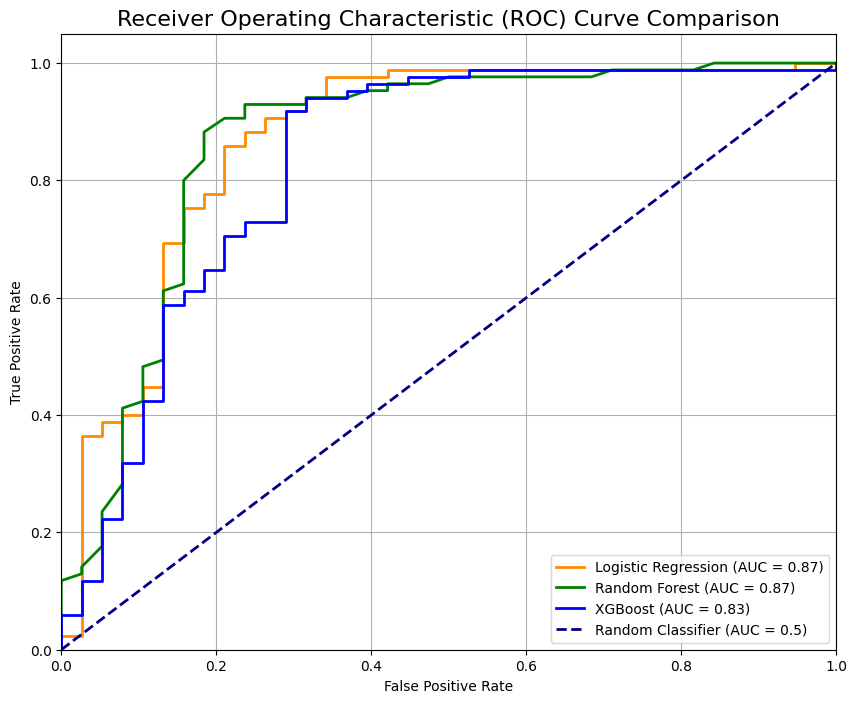

In [14]:
print("\n--- ROC Curves Comparison ---")

plt.figure(figsize=(10, 8))
plt.plot(fpr_lr, tpr_lr, color='darkorange', lw=2, label=f'Logistic Regression (AUC = {roc_auc_lr:.2f})')
plt.plot(fpr_rf, tpr_rf, color='green', lw=2, label=f'Random Forest (AUC = {roc_auc_rf:.2f})')
plt.plot(fpr_xgb, tpr_xgb, color='blue', lw=2, label=f'XGBoost (AUC = {roc_auc_xgb:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier (AUC = 0.5)')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve Comparison', fontsize=16)
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

Feature Importance Analysis

Extracting and visualizing feature importances from tree-based models.


--- Feature Importance Analysis ---

Random Forest Feature Importance:
                       Feature  Importance
5               Credit_History    0.446312
6                  TotalIncome    0.096758
7   LoanAmount_to_Income_Ratio    0.094322
1              ApplicantIncome    0.081252
3                   LoanAmount    0.074604
2            CoapplicantIncome    0.053570
17     Property_Area_Semiurban    0.030351
4             Loan_Amount_Term    0.027629
0                   Dependents    0.016407
12          Education_Graduate    0.012022


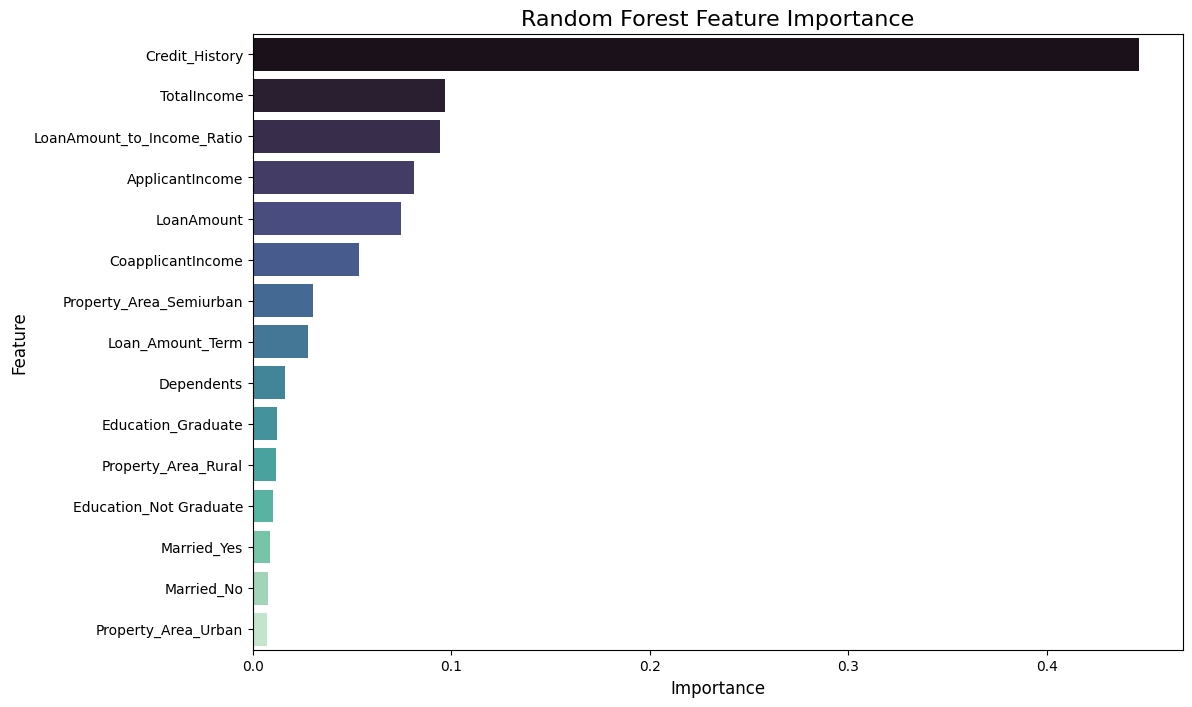


XGBoost Feature Importance:
                    Feature  Importance
5            Credit_History    0.380161
4          Loan_Amount_Term    0.064231
17  Property_Area_Semiurban    0.055086
6               TotalIncome    0.051429
14         Self_Employed_No    0.050444
16      Property_Area_Rural    0.048686
12       Education_Graduate    0.047541
2         CoapplicantIncome    0.046756
3                LoanAmount    0.041590
10               Married_No    0.041443


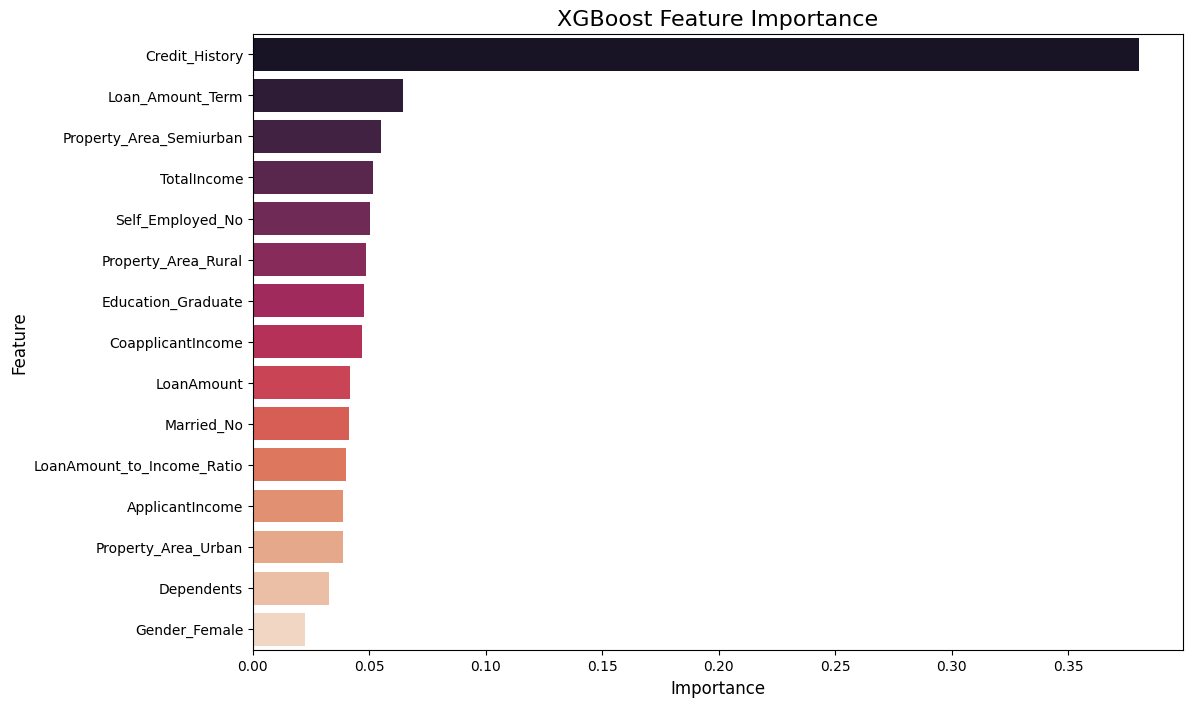

In [15]:
print("\n--- Feature Importance Analysis ---")

# To get feature names from the preprocessor:
# First, fit the preprocessor on the full dataset (or X_train if you prefer consistent names)
# so it learns the categories for one-hot encoding.
preprocessor.fit(X) # Using X (full data) to ensure all possible features are captured

# Get numerical features (scaled)
processed_numerical_features = numerical_features
# Get one-hot encoded categorical feature names
onehot_feature_names = preprocessor.named_transformers_['cat'].named_steps['onehot'].get_feature_names_out(categorical_features)

# Combine all processed feature names
all_processed_feature_names = list(processed_numerical_features) + list(onehot_feature_names)


# Random Forest Feature Importance
if hasattr(best_rf_model.named_steps['classifier'], 'feature_importances_'):
    rf_importances = best_rf_model.named_steps['classifier'].feature_importances_
    rf_feature_importance_df = pd.DataFrame({'Feature': all_processed_feature_names, 'Importance': rf_importances})
    rf_feature_importance_df = rf_feature_importance_df.sort_values(by='Importance', ascending=False)

    print("\nRandom Forest Feature Importance:")
    print(rf_feature_importance_df.head(10)) # Display top 10

    plt.figure(figsize=(12, 8))
    sns.barplot(x='Importance', y='Feature', data=rf_feature_importance_df.head(15), palette='mako') # Top 15
    plt.title('Random Forest Feature Importance', fontsize=16)
    plt.xlabel('Importance', fontsize=12)
    plt.ylabel('Feature', fontsize=12)
    plt.show()

# XGBoost Feature Importance
if hasattr(xgb_pipeline.named_steps['classifier'], 'feature_importances_'):
    xgb_importances = xgb_pipeline.named_steps['classifier'].feature_importances_
    xgb_feature_importance_df = pd.DataFrame({'Feature': all_processed_feature_names, 'Importance': xgb_importances})
    xgb_feature_importance_df = xgb_feature_importance_df.sort_values(by='Importance', ascending=False)

    print("\nXGBoost Feature Importance:")
    print(xgb_feature_importance_df.head(10)) # Display top 10

    plt.figure(figsize=(12, 8))
    sns.barplot(x='Importance', y='Feature', data=xgb_feature_importance_df.head(15), palette='rocket') # Top 15
    plt.title('XGBoost Feature Importance', fontsize=16)
    plt.xlabel('Importance', fontsize=12)
    plt.ylabel('Feature', fontsize=12)
    plt.show()

 Save the Best Model

Saving the best-performing model (the tuned Random Forest) for future use.

In [16]:
print("\n--- Saving the Best Model ---")

# Save the best model (e.g., the tuned Random Forest from GridSearchCV)
model_filename = 'loan_approval_classifier_rf_tuned.pkl'
joblib.dump(best_rf_model, model_filename)

print(f"Tuned Random Forest Model saved as '{model_filename}'")

# Example of how to load the model later:
# loaded_model = joblib.load(model_filename)
# print(f"Model loaded successfully: {loaded_model}")


--- Saving the Best Model ---
Tuned Random Forest Model saved as 'loan_approval_classifier_rf_tuned.pkl'
